# Browian Dynamics 
(BOAP algorithm: *BJ Leimkuhler and C Matthews Appl. Math. Res. eXpress 2013, 34–56 (2013); J. Chem. Phys. 138, 174102 (2013)*)



\begin{equation}
\bold{\dot{p}} = -\gamma\bold{p} + \sigma \bold{\dot{w}} 
\end{equation}
where:
<br>
1. $\gamma\bold{p}$ is the friction force. It simulates the effect of the bath (solvent).
<br>
2. $\sigma\bold{\dot{w}}$ is the random force, which is represented by the derivate of a Wiener process $\bold{w}$.
<br>
3. $\sigma = \sqrt{2 \xi k_B T}$ governs the strenght of the random force (it is related to the friction coefficient via the fluctuation-dissipation theorem)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython import display

In [2]:
np.random.seed(123)

def kick_step_propagator(t, p, f=None):
    """t is the time step (usually dt/2); p is the momentum which must be propagated """
    if f:
        return p + t * f
    else:
        return p 

def drift_step_propagator(t, r, p, box):
    r = r + t * (p / box)
    r = r - np.rint(r) # periodic bounderies
    return r
    
def random_step_propagator(t, p, gamma, T, n):
    """friction and random contributions propagator.
    t is the time over which to propagate (typically dt).
    gamma is the friction coefficient, T is the temperature, n is the number of particles
    """
    x = gamma * t
    c = 1 - np.exp(-2 * x) if x > 0.0001 else np.polyval([-2/3, 4/3, -2.0, 2.0, 0.0], x)
    c = np.sqrt(c)
    p = p * np.exp(-x) + c * np.sqrt(T) * np.random.randn(n, 3)
    return p

def main(t, r, p, gamma, box, T, n, nsteps, f=None):
    rs, ps = [], []
    for i in range(nsteps):
        p = kick_step_propagator(t * 0.5, p, f)
        r = drift_step_propagator(t * 0.5, r, p, box)
        p = random_step_propagator(t, p, gamma, T, n)
        rs.append(drift_step_propagator(t * 0.5, r, p, box))
        ps.append(kick_step_propagator(t * 0.5, p, f))
    return rs, ps

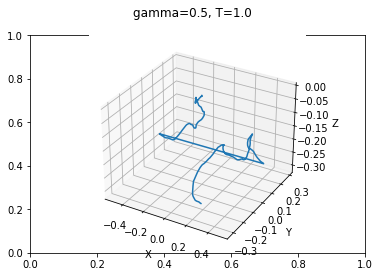

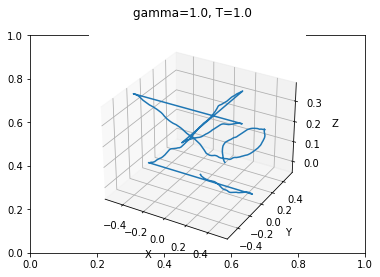

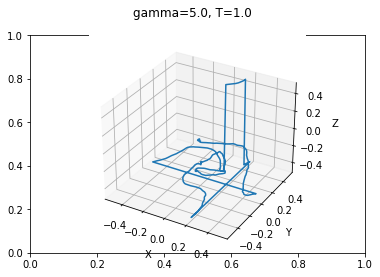

In [6]:
# Set default values, check keys and typecheck values
DT = 0.005
NSTEPS = 1000
T = [1.0]
GAMMA = [0.5, 1.0, 5.0]
N = 1
r = 0.0
p = 0.0
BOX = 1.0
F = 0.0
for i, g in enumerate(GAMMA):
    for temp in T:
        rs, ps = main(DT, r, p, g, BOX, temp, N, NSTEPS, F)
        xs = [x[0][0] for x in rs]
        ys = [x[0][1] for x in rs]
        zs = [x[0][2] for x in rs]

        pxs = [x[0][0] for x in ps]
        pys = [x[0][1] for x in ps]
        pzs = [x[0][2] for x in ps]

        fig_xs, ax1 = plt.subplots(1, 1)
        ax1 = fig_xs.add_subplot(projection='3d')
        fig_xs.suptitle(f'gamma={g}, T={temp}')
        _ = ax1.plot(xs, ys, zs, lw=1.5)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        plt.show()

In [7]:
def update_lines(num, walks, lines):
    for line, walk in zip(lines, walks):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(walk[:num, :2].T)
        line.set_3d_properties(walk[:num, 2])
    return lines


def save_gif():
    # Data: simulation of a 3D brownian dynamics of N particles
    rs, ps = main(DT, r, p, GAMMA, BOX, T, N, NSTEPS, F)
    rs = np.asarray(rs).reshape((N, NSTEPS, 3))
    
    # Attaching 3D axis to the figure
    fig = plt.figure()
    ax1 = fig.add_subplot(projection="3d")
    
    # Create lines initially without data
    lines = [ax1.plot([], [], [])[0] for _ in rs]
    
    # Setting the axes properties
    ax1.set(xlim3d=(-1, 1), xlabel='X')
    ax1.set(ylim3d=(-1, 1), ylabel='Y')
    ax1.set(zlim3d=(-1, 1), zlabel='Z')
    
    # Creating the Animation object
    anim = animation.FuncAnimation(
        fig, update_lines, NSTEPS, fargs=(rs, lines), interval=10)
    
    writergif = animation.PillowWriter(fps=30)
    anim.save(f'brownian_dynamics_g{GAMMA}.gif',writer=writergif)
    plt.close()